In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [19]:
# Loading the processed data
train_dataSVR = pd.read_csv('../Data/output/train_data.csv')
test_dataSVR = pd.read_csv('../Data/output/test_data.csv')
validation_dataSVR = pd.read_csv('../Data/output/validation_data.csv')

#Dates are converted to a numerical format because most models require numerical input
train_dataSVR['Date_ordinal'] = pd.to_datetime(train_dataSVR['Date']).map(pd.Timestamp.toordinal)
test_dataSVR['Date_ordinal'] = pd.to_datetime(test_dataSVR['Date']).map(pd.Timestamp.toordinal)
validation_dataSVR['Date_ordinal'] = pd.to_datetime(validation_dataSVR['Date']).map(pd.Timestamp.toordinal)


# Dropping column as no longer required
train_dataSVR.drop('Date', axis=1, inplace=True)
test_dataSVR.drop('Date', axis=1, inplace=True)
validation_dataSVR.drop('Date', axis=1, inplace=True)


In [20]:
# Separating target variable and features 
y_train = train_dataSVR['log_return']
X_train = train_dataSVR.drop(['log_return'], axis=1)

y_test = test_dataSVR['log_return']
X_test = test_dataSVR.drop(['log_return'], axis=1)

y_validation = validation_dataSVR['log_return']
X_validation = validation_dataSVR.drop(['log_return'], axis=1)

In [21]:
# Create an SVR model with pipeline and standard scaler
svr_pipeline = make_pipeline(StandardScaler(), SVR())

# Set up the parameter grid for C and epsilon
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 1],
    'svr__kernel': ['linear', 'rbf']
}

# Grid search with cross-validation
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best estimator
best_svr = grid_search.best_estimator_

# Predictions
y_train_pred = best_svr.predict(X_train)
y_test_pred = best_svr.predict(X_test)
y_validation_pred = best_svr.predict(X_validation)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__kernel': 'rbf'}


In [22]:
# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
validation_mse = mean_squared_error(y_validation, y_validation_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
validation_mae = mean_absolute_error(y_validation, y_validation_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
validation_r2 = r2_score(y_validation, y_validation_pred)

# Display the results

print("Training data")
print("MSE:", train_mse)
print("MAE:", train_mae)
print("R2:", train_r2)
print()


print("Testing data")
print("MSE:", test_mse)
print("MAE:", test_mae)
print("R2:", test_r2)
print()

print("Validation data")
print("MSE:", validation_mse)
print("MAE:", validation_mae)
print("R2:", validation_r2)




Training data
MSE: 0.024180490317815963
MAE: 0.056931682785194025
R2: 0.975819509682184

Testing data
MSE: 0.006271680790119538
MAE: 0.06194984149133322
R2: 0.9879627405796474

Validation data
MSE: 0.04943932878515618
MAE: 0.0838556862264183
R2: 0.939260282947882


In [32]:
# Create an SVR model with the best parameters
best_svr = SVR(C=10, epsilon=0.01, kernel='linear')

# Create a pipeline with standard scaler and the best SVR model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', best_svr)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the training data
y_train_pred = pipeline.predict(X_train)

# Predict on the validation data
y_validation_pred = pipeline.predict(X_validation)

# Predict on the test data
y_test_pred = pipeline.predict(X_test)

# Evaluate the model performance


train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
validation_mse = mean_squared_error(y_validation, y_validation_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
validation_mae = mean_absolute_error(y_validation, y_validation_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
validation_r2 = r2_score(y_validation, y_validation_pred)


# Output the performance
print(f"Training MSE: {train_mse}")
print(f"Validation MSE: {validation_mse}")
print(f"Test MSE: {test_mse}")


print("Training data")
print("MSE:", train_mse)
print("MAE:", train_mae)
print("R2:", train_r2)
print()


print("Testing data")
print("MSE:", test_mse)
print("MAE:", test_mae)
print("R2:", test_r2)
print()

print("Validation data")
print("MSE:", validation_mse)
print("MAE:", validation_mae)
print("R2:", validation_r2)
print()



Training MSE: 0.23273933322451243
Validation MSE: 0.050502721212884134
Test MSE: 0.028613915178091
Training data
MSE: 0.23273933322451243
MAE: 0.2856756296950223
R2: 0.7672606667754875

Testing data
MSE: 0.028613915178091
MAE: 0.13240796834612384
R2: 0.9450812100365076

Validation data
MSE: 0.050502721212884134
MAE: 0.1293497310600827
R2: 0.9379538300335181



In [25]:
# Use Ridge regression which includes L2 regularization
ridge = Ridge(alpha=1.0)  # alpha is the regularization parameter

# Create a pipeline with standard scaler and ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ridge)
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate R^2 score during cross-validation
cv_r2_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')



# Print the cross-validation scores
print(f"Cross-validation MSE: {-cv_scores.mean()}")

# Fit the pipeline on the full training data
pipeline.fit(X_train, y_train)

# Predict and evaluate on the validation set
y_validation_pred = pipeline.predict(X_validation)
validation_mse = mean_squared_error(y_validation, y_validation_pred)
print(f"Validation MSE: {validation_mse}")

# Print the cross-validation R^2 scores
print(f"Cross-validation R^2: {cv_r2_scores.mean()}")


Cross-validation MSE: 0.3836132128261462
Validation MSE: 0.09340184761018501
Cross-validation R^2: 0.5790340788166091


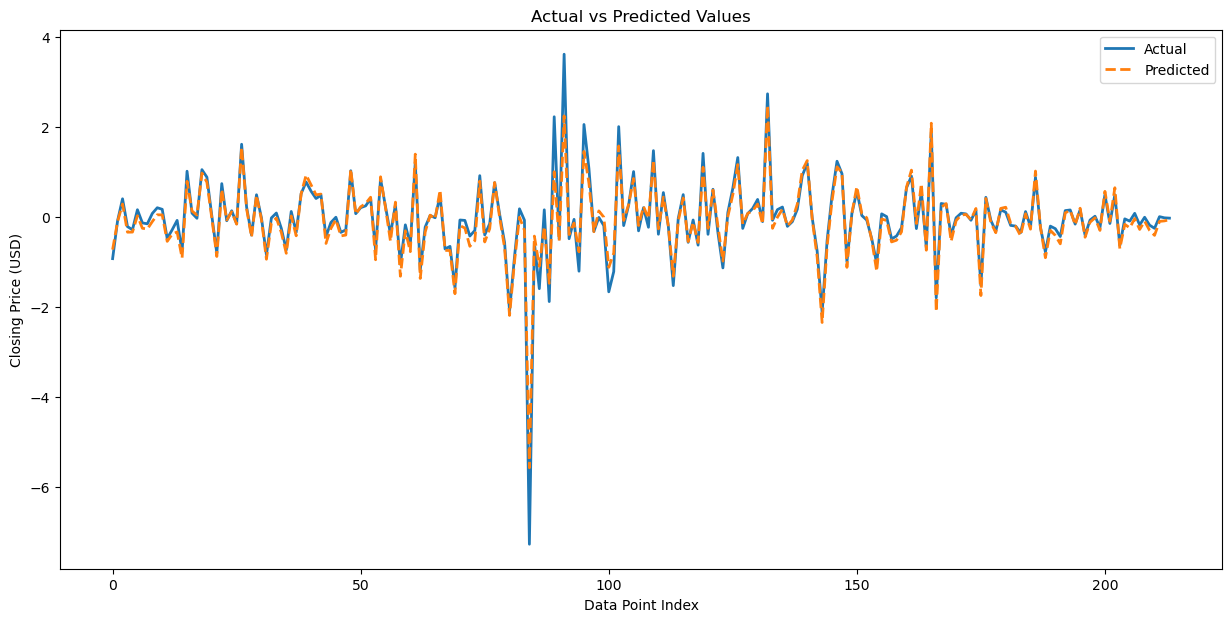

In [33]:
plt.figure(figsize=(15, 7))
plt.plot(y_validation.reset_index(drop=True), label='Actual', linewidth=2)
plt.plot(y_validation_pred, label='Predicted', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Data Point Index')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()


In [34]:
comparison_df = pd.DataFrame({'Actual': y_validation, 'Predicted': y_validation_pred})
print(comparison_df.head(10))


     Actual  Predicted
0 -0.924157  -0.722825
1 -0.081959  -0.099435
2  0.405970   0.289558
3 -0.212747  -0.336175
4 -0.282109  -0.334111
5  0.162715   0.028580
6 -0.129680  -0.248937
7 -0.149882  -0.265480
8  0.080591  -0.100309
9  0.207174   0.050497


In [35]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print(comparison_df.head(10))


     Actual  Predicted
0  1.043489   1.296714
1 -0.974149  -1.095142
2 -0.639558  -0.709616
3 -0.637950  -0.634701
4 -0.648225  -0.734882
5  0.234874   0.304295
6 -0.255002  -0.376010
7 -0.940413  -1.040925
8  0.076837   0.059592
9 -0.031475  -0.047509


In [36]:
comparison_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
print(comparison_df.head(10))


     Actual  Predicted
0 -0.057552  -0.276401
1  0.104225  -0.536708
2 -0.472504  -0.482279
3 -0.051631  -0.344122
4  0.129340  -0.333016
5 -0.226239  -0.362946
6 -0.217786  -0.207306
7  0.154745  -0.183035
8 -0.109302  -0.199750
9 -0.013962  -0.195681


In [31]:
#Saving the model


dump(pipeline, '../Data/models_output/svr_logreturn.joblib')


['../Data/models_output/svr_logreturn.joblib']

# SVR

The SVR model initially achieved an MSE of approximately 0.0242, an MAE of 0.0569, and an R^2 of 0.9758 on the **training data**. These metrics indicate an excellent fit to the training data, capturing a significant amount of variance.
On the **testing dataset**, the model performed great with an MSE of 0.0063, MAE of 0.0619, and an R^2 score of 0.988.
In the **validation set**, the model also demonstrated strong performance, albeit slightly lower than the testing set, with an MSE of 0.0494, MAE of 0.0839, and an R^2 of 0.9393.

#### Hyperparameter Tuning:
The grid search identified the optimal hyperparameters for the SVR model: C=10, epsilon=0.01, and the rbf kernel. These parameters were used to train the final model, which suggests a balance between model complexity (C) and the allowance for errors within the epsilon margin.

With the final hyperparameters, the SVR model achieved an MSE of approximately 0.2327, an MAE of 0.2857, and an R^2 of 0.7673 on the **training dataset**. This indicates a reasonable fit to the training data, though not as perfect as the initial fit before hyperparameter tuning, which is actually a good sign as it suggests less overfitting.
On the **testing dataset**, the final SVR model showed an MSE of 0.0286, MAE of 0.1324, and an R^2 score of 0.9451.
The **validation dataset** results were slightly less favorable with an MSE of 0.0505, MAE of 0.1293, and an R^2 of 0.9380. However, these metrics indicate that the model maintains a good performance level even on the validation set, which is critical for the model's use in a real-world setting.

#### Cross-validation Scores: 
The cross-validated MSE was reported to be 0.3836, with an R^2 of 0.5790. These metrics are not as strong as those obtained on the single test set, suggesting that the model's performance may vary depending on the specific subset of the data it's trained on.

#### Summary

**The SVR model** with the best parameters from hyperparameter tuning demonstrates good predictive ability, as shown by the testing and validation performance. While there is some variance in performance across different data subsets indicated by the cross-validation results, the model is generally robust and performs well on unseen data.
The relatively high R^2 scores on the test and validation sets suggest that the SVR model can capture a significant proportion of the variance in the logarithmic returns of Bitcoin prices. However, the less consistent cross-validation results imply that the model could benefit from further validation across different time periods or market conditions to assess its robustness.

